# 1D Least-squares Reverse Time Migration
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](http://www.ausargeo.com))*

Least-squares Reverse Time Migration formulates Reverse Time Migration as an iterative process that attempts to find a scattering model that matches the recorded data. In this notebook I test a simple 1D implementation. This is meant for demonstration purposes only, and the code will most likely not work well on real data.

## Theory
The theory of LSRTM is very similar to that of FWI, but in LSRTM we never update the background velocity model, only the scattering potential model.

The isotropic scalar wave equation is
$$ \nabla u(x, t) - \frac{1}{c^2(x)}\partial_{tt}u(x, t) = -f(x, t) $$
Separating the wave speed into a smooth background (which we will assume we know) and short wavelength changes (which is what we wish to image),
$$\frac{1}{c^2(x)} = \frac{1}{c_0^2(x)} - 2 \frac{c_1(x)}{c_0^3(x)}.$$
We also assume that the wavefield can be split into a term that only senses the smooth model, and a scattered term,
$$u(x, t) = u_0(x, t) + u_{sc}(x, t).$$
This gives
$$ \nabla (u_0(x, t)+u_{sc}(x,t)) - \left(\frac{1}{c_0^2(x)}-2\frac{c_1(x)}{c_0^3(x)}\right)\partial_{tt}(u_0(x, t)+u_{sc}(x,t)) = -f(x, t), $$
and
$$ \nabla u_0(x, t) - \frac{1}{c_0^2(x)}\partial_{tt}u_0(x, t) = -f(x, t). $$
Subtracting the second of these from the first gives
$$ \nabla u_{sc}(x, t) - \frac{1}{c_0^2(x)}\partial_{tt}u_{sc}(x, t) = -2\frac{c_1(x)}{c_0^3(x)}\partial_{tt}u(x, t). $$

Making the Born approximation, we assume that multiply scattered waves have negligible amplitude. That is, the scattered wavefield $u_{sc}$ is approximated as being only generated by interactions of $u_0$ with scatterers, and further interactions of $u_{sc}$ with the scatterers are ignored. This is expressed by changing $u$ to $u_0$ in the previous equation,
$$\nabla u_{sc}(x, t) - \frac{1}{c_0^2(x)}\partial_{tt}u_{sc}(x, t) = -2\frac{c_1(x)}{c_0^3(x)}\partial_{tt}u_0(x, t). $$
We can use this to calculate the scattered wavefield. Given a background model $c_0$, and a scattering model $c_1$, we can propagate a source wave through the background model to give us $u_0$, and multiply the second partial derivative of this by $-2\frac{c_1(x)}{c_0^3(x)}$ at each time step to create sources for the scattered wavefield. This is known as Born forward modeling or demigration.

Using the Green's function $G$ such that
$$ u_0(x, t) = \int_0^t dt' \int_V dx' G(x, x', t-t') f(x', t'), $$
$$ u_{sc}(x, t) = \int_0^t dt' \int_V dx' G(x, x', t-t') -2\frac{c_1(x')}{c_0^3(x')}\partial_{t't'}u_0(x', t'). $$

We're going to come back to that result in a moment, but first we need something else.

Let's define the cost function for our inversion as
$$ J(c_1) = \frac{1}{2}\sum_{s,r}|u_{sc}(x_{s,r}, t, c_1) - d_{s,r}(t)|^2, $$
where $s$ and $r$ index the shots and receivers, $x_{s,r}$ is the $x$ coordinate of receiver $r$ of shot $s$, $d_{s,r}$ is the observed/true data recorded at receiver $r$ of shot $s$ (ideally only containing the reflection arrivals), and u_sc{x, t, c_1) is the scattered wavefield with the scattering model $c_1$.

In order to know how to update our scattering model to reduce this cost function, we need the derivative with respect to the scattering model. For simplicity, let's define a new variable
$$\Delta c(x) = -2\frac{c_1(x)}{c_0^3(x)}.$$
Then the derivative is
$$ \frac{dJ}{d\Delta c} = \sum_{s,r}(u_{sc}(x_{s,r}, t, c_1) - d_{s,r}(t))\frac{\partial u_{sc}}{\partial \Delta c}. $$

Using our result from earlier, we get
$$ \frac{\partial u_{sc}(x_{s,r}, t, c_1)}{\partial \Delta c(x')} = \int_0^t dt' \int_V dx' G(x, x', t-t')\partial_{t't'}u_0(x', t'). $$

So,
$$ \frac{dJ}{d\Delta c} = \sum_{s,r}(u_{sc}(x_{s,r}, t, c_1) - d_{s,r}(t)) \int_0^t dt' \int_V dx' G(x, x', t-t') \partial_{t't'}u_0(x', t'). $$

Using the anticausal Green's function instead of the causal one, so performing backward propagation instead of forward, this derivative of the cost function with respect to the scattering potential (the gradient or Jacobian) can be calculated by backpropagating the residual $u_{sc}(x_{s,r}, t, c_1) - d_{s,r}(t)$ and multiplying at each time step by the second time derivative of forward propagated wavefield in the smooth model, and summing over shots. This is known as an adjoint-state method means of calculating the gradient.

Using this gradient to update the scattering model, we can iteratively improve the scattering model to reduce the misfit between the scattered wavefield and the true recorded data.

I have implemented this in `lsrtm.py`. Let's see how well it works.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from lsrtm_1d import lsrtm

In [3]:
from wave_1d_fd_pml import test_wave_1d_fd_pml

## Make the model
In the cell below I create two 1D models: a "true" model, and a smooth background/migration model. The true model is a smoothed random model, and the migration model is a further smoothing of this (smoothed in slowness domain). The top of the model is constant to make it easier to remove the direct arrival, so the data only contain scattered arrivals. I set the source and receiver position to be at the top of the model, to be similar to regular seismic experiments. Both models are plotted below.

In [105]:
N=50
dt=0.0005
dx=5
model=test_wave_1d_fd_pml.model_one(N=N)
model['sx']=[1]
v0=2500
model['model']=np.float32(np.ones(N)*v0)
model['model'][-int(N/2):] += np.float32(1000*(np.random.rand(int(N/2))-0.5))
h=3
model['model']=np.float32(np.convolve(np.ones(h)/h, np.pad(model['model'], int((h-1)/2), 'edge'), 'valid'))
h=11
migmodel=1/np.float32(np.convolve(np.ones(h)/h, np.pad(1/model['model'], int((h-1)/2), 'edge'), 'valid'))

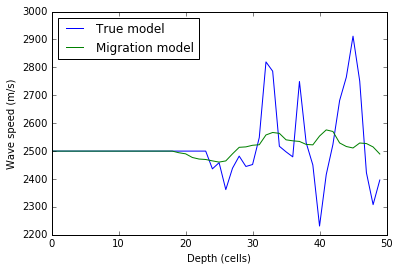

In [128]:
plt.plot(model['model'], label='True model')
plt.plot(migmodel, label='Migration model')
plt.ylabel('Wave speed (m/s)');
plt.xlabel('Depth (cells)');
plt.legend(loc=2);

In [107]:
r=lsrtm.Lsrtm(dx, dt, pml_width=20)

## Make synthetic data
I use the true model to create synthetic receiver data. There is only one receiver, and it is at the same location as the source. I mute the first half of the samples as these contain the direct wave. The result it plotted below.

In [108]:
maxt = 2*N*dx/v0
nmute = int(maxt/dt/2)
print(maxt, nmute)

0.2 200


In [109]:
d=r.model_shot(model['model'], model['sources'][0], model['sx'][0], model['sx'], maxt)
d[0, :nmute] = 0

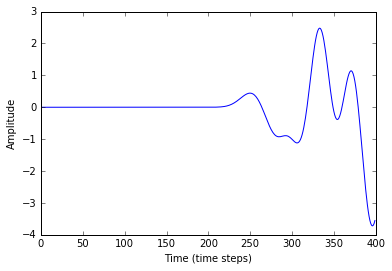

In [116]:
plt.plot(d.reshape(-1))
plt.xlabel('Time (time steps)')
plt.ylabel('Amplitude')

## Verification
To test the implementation, I compare the gradient calculated using the adjoint-state approach with a finite-difference estimate of the gradient calculated using the actual change in the cost function when I perturb the scattering model one cell at a time. The result, plotted below, shows that they agree very well, which is excellent news.

I also used Claerbout's adjoint test to further verify that all is well. The result, a few cells down, shows fairly good agreement.

In [21]:
costa, jaca = r.migrate_shot(migmodel, model['sources'][0], model['sx'][0], d, model['sx'], maxt, manual_check_grad=True)

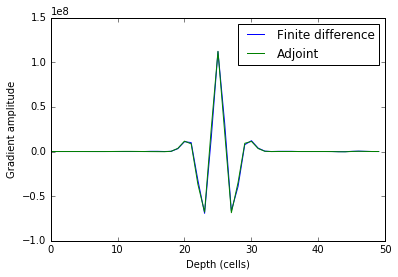

In [131]:
plt.plot(costa, label='Finite difference')
plt.plot(jaca, label='Adjoint')
plt.xlabel('Depth (cells)');
plt.ylabel('Gradient amplitude');
plt.legend();

In [69]:
r.adjoint_test(migmodel, model['sources'][0], int(maxt/dt))

3.12248e+07
3.8288e+07


There is a cause for concern, however, which is the size of the gradient: up to about 1e8, which is very large. As is typical in seismic codes, I use single precision floats everywhere, so a response of this size (suggesting that changing the scattering amplitude by 1 will change the cost function by 1e8) creates the risk of numerical troubles. Indeed, when I ran the inversion using SciPy's `minimize` method, it failed because of a "loss of precision", which I suspect is related to this issue. To overcome this, I used bounded inversion, limiting the possible range of scattering amplitudes. Assuming that there would not be a scattering potential corresponding to changes larger than 15000 m/s from the migration model (a very safe estimate, I think), I chose the bounds on the scattering amplitude to be -2e-6 to 2e-6 (see calculation in next cell).

I then encountered a problem with SciPy's default bounded minimization method: it requires inputs to be 64-bit floats instead of 32-bit. I therefore switched to the Truncated Newton method, which doesn't require this.

When I ran this inversion (using my `migrate_shot` function), it converged.

I also tried implementing the method when the inversion target was $c_1$ instead of $\Delta c$. This worked a bit better, since the gradient is much smaller, but I still got the "loss of precision" error with the default solver after a few iterations. The results below are from the bounded $\Delta c$ inversion.

In [121]:
-2*15000/2500**3

-1.92e-06

In [111]:
res=r.migrate_shot(migmodel, model['sources'][0], model['sx'][0], d, model['sx'], 200)

In [112]:
res

     fun: 10.938998
     jac: array([ -2.14325744e+08,  -1.06657304e+08,   5.33202000e+06,
         8.81195840e+07,   1.33861888e+08,   1.49572928e+08,
         1.42669264e+08,   1.12566792e+08,   5.69571280e+07,
        -1.38856110e+07,  -6.96683600e+07,  -8.17304480e+07,
        -5.50669320e+07,  -2.79486720e+07,  -2.31660880e+07,
        -9.33584100e+06,   6.45921280e+07,   1.89302368e+08,
         2.65421504e+08,   1.88393440e+08,  -1.79515680e+07,
        -1.79513184e+08,  -1.46264528e+08,   4.07439575e+06,
         3.20864160e+07,  -1.41219648e+08,  -2.86566144e+08,
        -1.61485168e+08,   1.37743792e+08,   2.92141152e+08,
         1.64276640e+08,  -6.47387840e+07,  -1.61187936e+08,
        -1.01831384e+08,  -1.91373240e+07,  -9.19978000e+05,
        -1.06498440e+07,   1.85303800e+07,   6.30834400e+07,
         3.51265720e+07,  -6.57210120e+07,  -1.20632688e+08,
        -6.30996440e+07,   3.22569060e+07,   7.05484960e+07,
         4.84550960e+07,   1.16541920e+07,  -1.28906250

## Results
The inverted $\Delta c$ is plotted below. A more interesting plot is the one below that.

Since the amplitudes in our observed data are correct (something that is unfortunately typically not at all true for real data), in this case we can relate the inverted scattering amplitudes to actual changes in model wave speed. When we add these inverted wave speeds to the migration wave speed, the result should be close to the true model, if the inversion was successful.

To do this, we recall that
$$\Delta c(x) = -2\frac{c_1(x)}{c_0^3(x)},$$
so
$$c_1(x) = -\frac{\Delta c(x) c_0^3(x)}{2}.$$
And since $c_1$ are the perturbations to $c_0$,
$$c(x)  = c_0(x) + c_1(x).$$

The interesting plot a few cells down thus compares the original migration model ($c_0$), the migration model plus the inverted perturbation ($c_0 + c_1$), and the true model ($c$). I think the results are pretty impressive. The only major discrepancy is at the bottom of the model, which is not surprising as this is not fully recorded by the observed data (the recorded data above cuts off in the middle of a big reflection arrival).

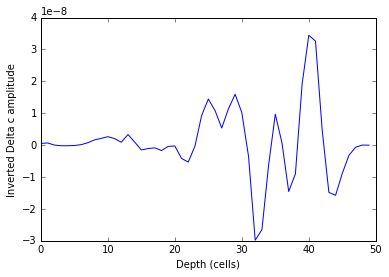

In [123]:
plt.plot(res.x)
plt.xlabel('Depth (cells)')
plt.ylabel('Inverted Delta c amplitude')

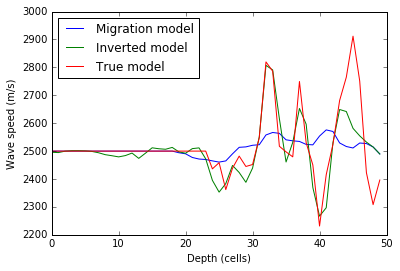

In [132]:
plt.plot(migmodel, label='Migration model')
plt.plot(migmodel-res.x*migmodel**3/2, label='Inverted model')
plt.plot(model['model'], label='True model')
plt.xlabel('Depth (cells)');
plt.ylabel('Wave speed (m/s)');
plt.legend(loc=2);

## Conclusion
LSRTM worked quite well in this test. There were some numerical issues, as I discussed above, but otherwise implementation was quite simple. LSRTM is a very expensive method, however, at least using my simplistic implementation. The inversion above required more than 100 evaluations of the cost function (each of which requires Born forward modeling of all shots), and 10 evaluations of the gradient (each equivalent to one application of RTM). For a large 3D model, this might be prohibitively expensive. 